Epoch 1/50
17/17 [==============================] - 4s 204ms/step - loss: 0.2250 - val_loss: 0.0433
Epoch 2/50
17/17 [==============================] - 3s 202ms/step - loss: 0.0038 - val_loss: 4.3817e-06
Epoch 3/50
17/17 [==============================] - 3s 200ms/step - loss: 1.8441e-06 - val_loss: 4.3817e-06
Epoch 4/50
17/17 [==============================] - 3s 198ms/step - loss: 1.8441e-06 - val_loss: 4.3817e-06
Epoch 5/50
17/17 [==============================] - 3s 192ms/step - loss: 1.8441e-06 - val_loss: 4.3817e-06
Epoch 6/50
17/17 [==============================] - 3s 199ms/step - loss: 1.8441e-06 - val_loss: 4.3817e-06
Epoch 7/50
17/17 [==============================] - 4s 213ms/step - loss: 1.8441e-06 - val_loss: 4.3817e-06
Epoch 8/50
17/17 [==============================] - 4s 222ms/step - loss: 1.8441e-06 - val_loss: 4.3817e-06
Epoch 9/50
17/17 [==============================] - 4s 219ms/step - loss: 1.8441e-06 - val_loss: 4.3817e-06
Epoch 10/50
17/17 [=====================

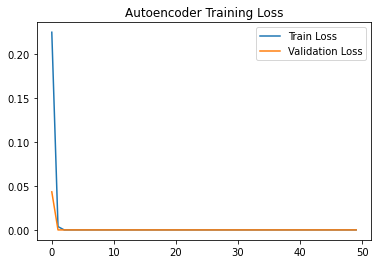

42/42 [==============================] - 1s 17ms/step
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost model saved to ./models/xgb_model_2.pkl


In [3]:
import os
import numpy as np
import pandas as pd
import opensmile
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import load_model
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

train_dir = "./data/Standardized_Data/training/"
autoencoder_path = "./models/autoencoder_model.h5"
xgb_model_path = "./models/xgb_model_2.pkl"

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

def extract_features(folder_path):
    features, labels = [], []
    classes = {"COPD_Segments": 0, "Healthy_Segments": 1}
    for label, class_num in classes.items():
        folder = os.path.join(folder_path, label)
        for file_name in os.listdir(folder):
            if file_name.endswith(".wav"):
                file_path = os.path.join(folder, file_name)
                feature = smile.process_file(file_path).values.flatten()
                features.append(feature)
                labels.append(class_num)
    return np.array(features), np.array(labels)

# Load and preprocess data
X, y = extract_features(train_dir)
X = (X - X.min()) / (X.max() - X.min())  # Normalize
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_val = train_test_split(X_resampled, test_size=0.2, random_state=42)

input_dim = X.shape[1]
latent_dim = 1024

input_layer = Input(shape=(input_dim,))
encoded = Dense(2048, activation='relu')(input_layer)
encoded = Dense(latent_dim, activation='relu')(encoded)
decoded = Dense(2048, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(
    X_train, X_train,
    epochs=50, batch_size=64, validation_data=(X_val, X_val), verbose=1
)
autoencoder.save(autoencoder_path)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Autoencoder Training Loss")
plt.show()

X_encoded = encoder.predict(X_resampled)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}
xgb_model = XGBClassifier(random_state=42, n_jobs=-1)
grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    scoring='accuracy',
    cv=3,
    n_iter=10,
    verbose=1,
    random_state=42,
)
grid_search.fit(X_encoded, y_resampled)

best_model = grid_search.best_estimator_
joblib.dump(best_model, xgb_model_path)
print(f"Best XGBoost model saved to {xgb_model_path}")


7/7 [==============================] - 0s 13ms/step
Classification Report:
              precision    recall  f1-score   support

        COPD       0.89      0.92      0.91       176
     Healthy       0.07      0.05      0.06        21

    accuracy                           0.83       197
   macro avg       0.48      0.48      0.48       197
weighted avg       0.80      0.83      0.81       197



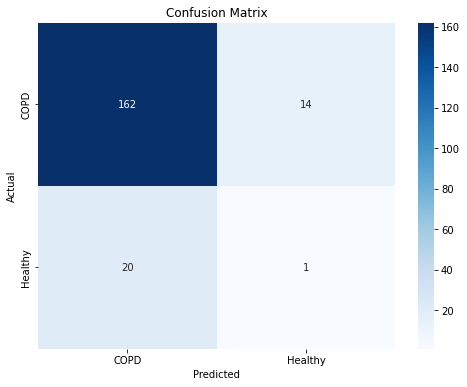

In [4]:
import os
import numpy as np
import pandas as pd
import opensmile
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_dir = "./data/Standardized_Data/testing/"
autoencoder_path = "./models/autoencoder_model.h5"
xgb_model_path = "./models/xgb_model_2.pkl"

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

def extract_features(folder_path):
    features, labels = [], []
    classes = {"COPD_Segments": 0, "Healthy_Segments": 1}
    for label, class_num in classes.items():
        folder = os.path.join(folder_path, label)
        for file_name in os.listdir(folder):
            if file_name.endswith(".wav"):
                file_path = os.path.join(folder, file_name)
                feature = smile.process_file(file_path).values.flatten()
                features.append(feature)
                labels.append(class_num)
    return np.array(features), np.array(labels)

X_test, y_test = extract_features(test_dir)
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

autoencoder = load_model(autoencoder_path)
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-3].output)
xgb_model = joblib.load(xgb_model_path)

X_test_encoded = encoder.predict(X_test)

y_pred = xgb_model.predict(X_test_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["COPD", "Healthy"]))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["COPD", "Healthy"], yticklabels=["COPD", "Healthy"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
